# Cifar10 Classifier
Cifar10 is a dataset with 10 classes containing 6000 images for each class. In this notebook, you will see how Batch Normalization speed up the training.

# Import Libraries

## Install Tensorflow 2

In [0]:
!pip install tensorflow-gpu -q

In [0]:
import tensorflow as tf

tf.__version__

'2.1.0'

## Import other libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical

np.set_printoptions(precision=7)
np.random.seed(42)
%matplotlib inline

# Cifar10 Tensorflow Dataset

In this tutorial, we are using Cifar10 data from Tensorflow dataset, you can see the details here https://www.tensorflow.org/datasets/catalog/cifar10

## Create directory for dataset

In [0]:
import os

data_dir = 'dataset'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)

## Download Cifar10 dataset

In [0]:
dataset_name = 'cifar10'

(train_set, test_set), dataset_info =  tfds.load( 
              name = dataset_name, 
              split = ['train', 'test'], 
              with_info = True, 
              data_dir = data_dir
          )

## Dataset Information

In [0]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



## Detailed Information

In [0]:
class_names =  dataset_info.features["label"].names

print('image shape    :', dataset_info.features['image'].shape)
print('image dtype    :', dataset_info.features['image'].dtype)
print()
print('num class      : ',dataset_info.features["label"].num_classes)
print('class label    :', dataset_info.features["label"].names)
print()
print('num train data :', dataset_info.splits["train"].num_examples)

image shape    : (32, 32, 3)
image dtype    : <dtype: 'uint8'>

num class      :  10
class label    : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num train data : 50000


## Show Images

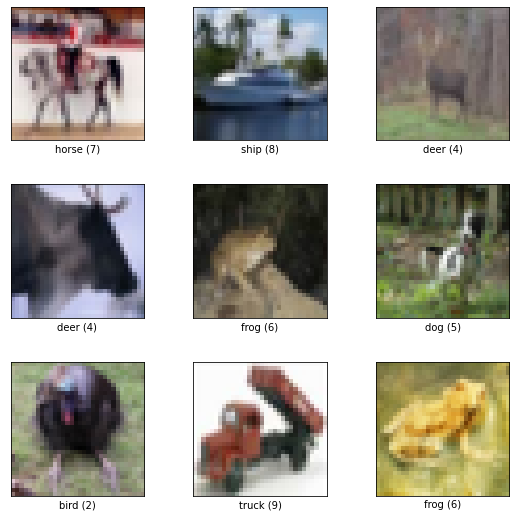

In [0]:
fig = tfds.show_examples(dataset_info, train_set)

Since Cifar10 has the same size for each image, so we don't need to resize the image. All we have to do is convert the image type as numpy array and normalize every pixel.

# Preprocess Image

## Convert Image Type

In [0]:
X_train_ori = []
y_train_ori = []

X_test_ori = []
y_test_ori = []

for example in tfds.as_numpy(train_set):
    new_img = example['image']
    X_train_ori.append(new_img)
    y_train_ori.append(example['label'])
del train_set

for example in tfds.as_numpy(test_set):
    new_img = example['image']
    X_test_ori.append(new_img)
    y_test_ori.append(example['label'])
del test_set

# Convert train data to numpy array
X_train_ori = np.asarray(X_train_ori)
y_train_ori = np.asarray(y_train_ori)

# Convert test data to numpy array
X_test_ori = np.asarray(X_test_ori)
y_test_ori = np.asarray(y_test_ori)

# One hot label
y_train_hot = to_categorical(y_train_ori)
y_test_hot = to_categorical(y_test_ori)

## Normalize Data

In [0]:
mean_pixel = X_train_ori.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train_ori.std(axis=(0, 1, 2), keepdims=True)

X_train = ((X_train_ori - mean_pixel) / std_pixel).astype('float32')

X_test = ((X_test_ori - mean_pixel) / std_pixel).astype('float32')

# Split Train Data into Train and Validaiton

In [0]:
# Set the length of Train data
dataset_size = len(X_train)
train_idx = int(0.8 * dataset_size)

# Split for val data
X_val = X_train[train_idx:, :]
y_val_hot = y_train_hot[train_idx:]

# Split for train data
X_train = X_train[:train_idx, :]
y_train_hot = y_train_hot[:train_idx]

print('X_train.shape =', X_train.shape)
print('X_val.shape =', X_val.shape)
print('X_test.shape =', X_test.shape)

print('y_train.shape =', y_train_hot.shape)
print('y_val.shape =', y_val_hot.shape)
print('y_test.shape =', y_test_hot.shape)

X_train.shape = (40000, 32, 32, 3)
X_val.shape = (10000, 32, 32, 3)
X_test.shape = (10000, 32, 32, 3)
y_train.shape = (40000, 10)
y_val.shape = (10000, 10)
y_test.shape = (10000, 10)


# Data Augmentation

In [0]:
data_gen_args = dict(
    rotation_range=0,
    width_shift_range= 0.1,
    height_shift_range= 0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

datagen = ImageDataGenerator(**data_gen_args)
datagen.fit(X_train)
augmented_train = datagen.flow(
    X_train, y_train_hot, batch_size
)

# Classification Model

Let's go to the deeper model with 0.5 probability of Dropout.

In [0]:
model1 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),    
    Dropout(0.5),
    Dense(units=10, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         2

In [0]:
history = []

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model1.fit_generator(augmented_train, validation_data = (X_val, y_val_hot), epochs=20)

history.append(his)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate on 10000 samples
Epoch 1/20
625/625 [==============================] - 20s 32ms/step - loss: 1.7845 - accuracy: 0.3084 - val_loss: 1.4013 - val_accuracy: 0.4828
Epoch 2/20
625/625 [==============================] - 18s 29ms/step - loss: 1.3314 - accuracy: 0.5175 - val_loss: 1.2199 - val_accuracy: 0.5662
Epoch 3/20
625/625 [==============================] - 18s 29ms/step - loss: 1.1273 - accuracy: 0.6051 - val_loss: 1.0232 - val_accuracy: 0.6480
Epoch 4/20
625/625 [==============================] - 19s 30ms/step - loss: 1.0113 - accuracy: 0.6533 - val_loss: 0.9844 - val_accuracy: 0.6533
Epoch 5/20
625/625 [==============================] - 18s 29ms/step - loss: 0.9403 - accuracy: 0.6813 - val_loss: 0.7916 - val_accuracy: 0.7237
Epoch 6/20
625/625 [==============================] - 19s 30ms/step - loss: 0.8791 - accuracy: 0.7029 - val_loss: 0.7818 - val_accuracy: 0.7280
Epoch 7/20
625/625 [==============================] - 18s 30ms/step - loss: 0.8269 - accu

In [0]:
model2 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),    

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),    

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),    
    Dropout(0.5),
    Dense(units=10, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)      

In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model2.fit_generator(augmented_train, validation_data = (X_val, y_val_hot), epochs=20)

history.append(his)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate on 10000 samples
Epoch 1/20
625/625 [==============================] - 20s 31ms/step - loss: 1.9671 - accuracy: 0.2907 - val_loss: 1.5306 - val_accuracy: 0.4548
Epoch 2/20
625/625 [==============================] - 19s 30ms/step - loss: 1.5295 - accuracy: 0.4353 - val_loss: 1.5134 - val_accuracy: 0.4563
Epoch 3/20
625/625 [==============================] - 19s 31ms/step - loss: 1.2957 - accuracy: 0.5407 - val_loss: 1.2230 - val_accuracy: 0.5927
Epoch 4/20
625/625 [==============================] - 19s 30ms/step - loss: 1.1241 - accuracy: 0.6141 - val_loss: 1.1164 - val_accuracy: 0.6294
Epoch 5/20
625/625 [==============================] - 19s 30ms/step - loss: 1.0005 - accuracy: 0.6636 - val_loss: 0.9040 - val_accuracy: 0.6843
Epoch 6/20
625/625 [==============================] - 19s 30ms/step - loss: 0.8951 - accuracy: 0.7043 - val_loss: 0.8558 - val_accuracy: 0.7186
Epoch 7/20
625/625 [==============================] - 19s 30ms/step - loss: 0.8317 - accu

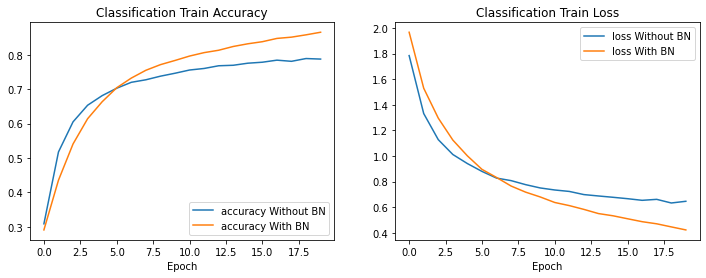

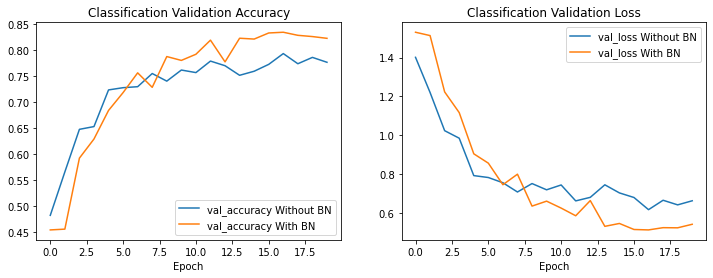

In [0]:
model_name = ["Without BN", "With BN"]

plt.rcParams['figure.figsize'] = [12, 4]
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(1, 2, 1)
for i, name in enumerate(model_name):
  plt.plot(history[i].history['accuracy'], label='accuracy ' + name)
plt.title("Classification Train Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for i, name in enumerate(model_name):
  plt.plot(history[i].history['loss'], label='loss ' + name)
plt.title("Classification Train Loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
for i, name in enumerate(model_name):
  plt.plot(history[i].history['val_accuracy'], label='val_accuracy ' + name)
plt.title("Classification Validation Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for i, name in enumerate(model_name):
  plt.plot(history[i].history['val_loss'], label='val_loss ' + name)
plt.title("Classification Validation Loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate Model

## Model Performance without Batch Normalization

In [0]:
train_scores = model1.evaluate(X_train, y_train_hot, batch_size=16, verbose=1)
test_scores  = model1.evaluate(X_test, y_test_hot, batch_size=16, verbose=1)
val_scores   = model1.evaluate(X_val, y_val_hot, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

10000/10000 [==============================] - 2s 176us/sample - loss: 0.6619 - accuracy: 0.7768
Train Loss: 0.54122 with Accuracy: 81.2%
Test  Loss: 0.66061 with Accuracy: 77.6%
Val   Loss: 0.66188 with Accuracy: 77.7%


## Model Performance with Batch Normalization

In [0]:
train_scores = model2.evaluate(X_train, y_train_hot, batch_size=16, verbose=1)
test_scores  = model2.evaluate(X_test, y_test_hot, batch_size=16, verbose=1)
val_scores   = model2.evaluate(X_val, y_val_hot, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

10000/10000 [==============================] - 2s 179us/sample - loss: 0.5408 - accuracy: 0.8228
Train Loss: 0.40741 with Accuracy: 86.4%
Test  Loss: 0.56519 with Accuracy: 82.1%
Val   Loss: 0.54078 with Accuracy: 82.3%


As we can see, the network with Batch Normalization could study better than the network without Batch Normalization. Let's see what is Batch Normalization.

# Batch Normalization

Batch Normalization is one of regularization techniques that is used in CNN. The aim is to make the network learn better by normalizing the output of a convolution layer before go to the next convolution layer. It enables us to opt for higher learning rates and use sigmoid activation functions even for Deep Neural Networks. It addresses <font color = 'red'>gradient vanishing</font> and <font color = 'red'>gradient explosion</font> by countering the <font color = 'blue'>Internal Covariate Shift</font>.

## Internal Covariate Shift

When we train the Neural networks, the training data will go into the network and the error between the expected value and the output value from the Neural network is calculated. The weight update of nueral network is done using one of some optimization techniques, such as SGD, AdaGrad, Adam, RMSprop, etc.

In the context of Neural networks, they are <font color='blue'> optimized using batches of data </font> being fed into the network. If the training and test data have <font color='red'> different sources </font>, they will have <font color='red'> different distributions</font>. These batches of inputs can have a <font color='red'> different distribution</font>, i.e. a slightly varying mean and variance from the sample (i.e., entire dataset considered) mean and variance.

The weights of various layers of the Neural networks are updated while training. This means that the <font color='red'> activation function changes </font> throughout training, and these weights are then fed into the next layer. Now, when the input distribution of the next batch (or set of inputs) is different, the Neural network is <font color='red'> forced to change and adapt </font> according to the changing input batches. So, training Neural networks becomes much more complex when the values of parameters change continuously with new input batches. This changing parameter value slows down the training process by requiring lower learning rates and more careful optimization. We define <font color='red'> Internal Covariate Shift </font> as the change in the distribution of network activations due to the change in network parameters during training.

<p align=center>
<img src="https://github.com/Malikanhar/Deep-Learning-for-Image-Classification/raw/master/More%20Flavor%20with%20Batch%20Normalization/Images/internal_covariate_shift.JPG" width='600'><br>
</p>

<font color='blue'> Batch Normalization </font> is the solution to the <font color='red'> internal covariate shift </font> and makes the optimization care less about the initialization.

## Addressing the Internal Covariate Shift
It is already known that the loss function would converge faster if it is <font color = 'blue'>whitened</font> — i.e., linearly transformed to have zero means and unit variances, and decorrelated. This whitening process could be done at every step of training or a fixed interval. If the input data batches have been <font color = 'blue'>whitened</font> (either at every training step or some intervals), it would be a step towards <font color = 'blue'> addressing</font> the <font color = 'red'>internal covariate shift</font>.

source : https://medium.com/towards-artificial-intelligence/why-batch-normalization-matters-4a6d753ba309

## How Does Batch Normalization Work?

- First, compute the empirical <font color = 'blue'>mean</font> and <font color = 'blue'>variance</font> for each batch.

<p align=center>
<img src="https://github.com/Malikanhar/Deep-Learning-for-Image-Classification/raw/master/More%20Flavor%20with%20Batch%20Normalization/Images/mean_formula.JPG" height='65'><br>
</p>

<p align=center>
<img src="https://github.com/Malikanhar/Deep-Learning-for-Image-Classification/raw/master/More%20Flavor%20with%20Batch%20Normalization/Images/var_formula.JPG" height='65'><br>
</p>

- Then, <font color = 'blue'>normalize</font> the input.

<p align=center>
<img src="https://github.com/Malikanhar/Deep-Learning-for-Image-Classification/raw/master/More%20Flavor%20with%20Batch%20Normalization/Images/norm_formula.JPG" height='60'><br>
</p>

- Finally, <font color = 'blue'>scale</font> and <font color = 'blue'>shift</font> the data by squashing through a linear funtion with parameters <font color = 'red'>gamma</font> and <font color = 'red'>beta</font>.

<p align=center>
<img src="https://github.com/Malikanhar/Deep-Learning-for-Image-Classification/raw/master/More%20Flavor%20with%20Batch%20Normalization/Images/scale_shift_formula.JPG" height='25'><br>
</p>

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/malikanhar/>2019 - MALIK</a> </p>